## Описание проекта


Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, X360 или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2022 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных


-  Name — название игры
-  Platform — платформа
-  Year_of_Release — год выпуска
-  Genre — жанр игры
-  NA_sales — продажи в Северной Америке (миллионы проданных копий)
-  EU_sales — продажи в Европе (миллионы проданных копий)
-  JP_sales — продажи в Японии (миллионы проданных копий)
-  Other_sales — продажи в других странах (миллионы проданных копий)
-  Critic_Score — оценка критиков (максимум 100)
-  User_Score — оценка пользователей (максимум 10)
-  Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию


## Шаг 1. Открываем файл с данными

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy. stats import ttest_ind

data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv', index_col=0)

[Данные доступны по ссылке](https://www.kaggle.com/datasets/sidtwr/videogames-sales-dataset?select=Video_Games_Sales_as_at_22_Dec_2016.csv)

### Первичное преобразование данных
Приводим все столбцы к нижнему регистру. Заменяем Nan на 0, так как такое отсутствие данных присутствует в показателе рейтинга пользователей, критиков и т.д. Также переведём столбец с годами выпуска игры в целочисленный формат данных. Причины, которые могли привести к пропускам:
- Для пропусков в столбцах рейтингов: отсутствие игры на различных платформах для оценки продуктов
    - Для пропусков в разделе разработчиков: 
        - Для старых игр (до 2000-ого года): Утеря данных вследствие малой развитости интернета и игровой индустрии
        - Для новых игр (после 2000-ого года): Возможно, игра была разработана частным лицом или группой лиц, не имеющих названия
- В общем случае, при отсутствии большого кол-ва данных, проблема может состоять в простом сбое выгрузки данных

In [49]:
data.columns = data.columns.str.lower()

col_list = list(data.columns)

for i in range(len(col_list)):
    counter = data[col_list[i]].isnull().sum()
    if counter == 0:
        col_list[i] = ""
col_list = list(filter(None, col_list))
print(col_list)
data.info()

['year_of_release', 'genre', 'publisher', 'critic_score', 'critic_count', 'user_score', 'user_count', 'developer', 'rating']
<class 'pandas.core.frame.DataFrame'>
Index: 16719 entries, Wii Sports to Winning Post 8 2016
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   platform         16719 non-null  object 
 1   year_of_release  16450 non-null  float64
 2   genre            16717 non-null  object 
 3   publisher        16665 non-null  object 
 4   na_sales         16719 non-null  float64
 5   eu_sales         16719 non-null  float64
 6   jp_sales         16719 non-null  float64
 7   other_sales      16719 non-null  float64
 8   global_sales     16719 non-null  float64
 9   critic_score     8137 non-null   float64
 10  critic_count     8137 non-null   float64
 11  user_score       7590 non-null   float64
 12  user_count       7590 non-null   float64
 13  developer        10096 non-null  object 
 14  rating 

    
<div class="alert alert-warning">
Можно еще вот так

</div>

In [50]:
#data.isna().sum(axis=0)

Заметим, что часть колонок, обладающих Nan значением была в типе object, часть во float.
В пустых строках типа float заполним нулями. 
В пустых строках типа object заполним строками "noinf"

    
<div class="alert alert-warning">
Можно еще вот так

</div>

In [51]:
# data.loc[:, col_list] = data.loc[:, col_list].fillna(0)

In [52]:
data['year_of_release'], data['critic_score'], data['critic_count'], data['user_score'], data['user_count'] = data['year_of_release'].fillna(0), data['critic_score'].fillna(0), data['critic_count'].fillna(0), data['user_score'].fillna(0), data['user_count'].fillna(0)
data['genre'], data['publisher'], data['developer'], data['rating'] = data['genre'].fillna('noinf'), data['publisher'].fillna('noinf'), data['developer'].fillna('noinf'), data['rating'].fillna('noinf')

data.year_of_release = data.year_of_release.astype(int)
mask = (data['year_of_release'] != 0)
data = data.loc[mask]

Посмотрим какие года в целом есть в нашей таблице и заметим пропуск между 2017 и 2020 годом
Проверив кол-во игр, которые соответствуют 2020-ому году, найдём лишь одну. Предположим, что этот результат есть просто ошибка в указании года выпускам(проверено - по факту 2008\2009)

In [53]:
years = data['year_of_release'].unique()
print(years)

mask22 = (data['year_of_release'] == 2020)
mass = data.loc[mask22]
mass

[2006 1985 2008 2009 1996 1989 1984 2005 1999 2007 2010 2013 2004 1990
 1988 2002 2001 2011 1998 2015 2012 2014 1992 1997 1993 1994 1982 2016
 2003 1986 2000 1995 1991 1981 1987 1980 1983 2020 2017]


,platform,year_of_release,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,critic_count,user_score,user_count,developer,rating
Name,,,,,,,,,,,,,,,
Imagine: Makeup Artist,DS,2020,Simulation,Ubisoft,0.27,0.0,0.0,0.02,0.29,0.0,0.0,0.0,0.0,Ubisoft,E


In [54]:
mask22 = (data['year_of_release'] != 2020) & (data['year_of_release'] != 2017)
data = data.loc[mask22]

## Исследовательский анализ данных
Посмотрим сколько игр выпускалось в разные годы и как менялись продажи по платформам

Построим графики, отражающие продажи в млн. экземпляров для годов в период в 2000 по 2017 для платформ с топ 3 по продажам. Остальные года (до 2000-ого) на графике отображать не имеет смысла, так как продаж там нет никаких.

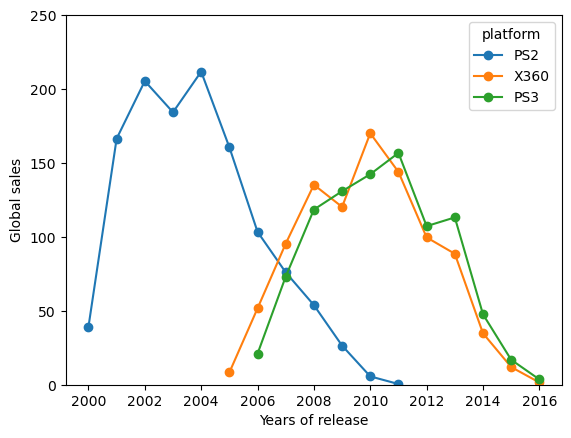

In [55]:
data_one = data.pivot_table(
    values='global_sales',
    columns='year_of_release',
    index='platform',
    aggfunc='sum'
)

data_one['my_sum'] = data_one.sum(axis=1)
new = data_one.sort_values(by='my_sum', ascending=False).head(3).T
new = new.drop(index=list(range(1980, 2000)))
new = new.drop(index ='my_sum')
new.plot(ylim=[0, 250], marker='o', xlabel='Years of release', ylabel='Global sales');

 Как можно видеть, лидирующими платформами оказались:PS2, X360, PS3. Характерный срок между появлением и исчезновением составляет примерно 10 лет. 

Посмотрим, что вообще происходит с игровой индустрией и помимо самых успешных компаний.

Построим графики для компаний, основной рост продаж для которых начался в последние 10 лет

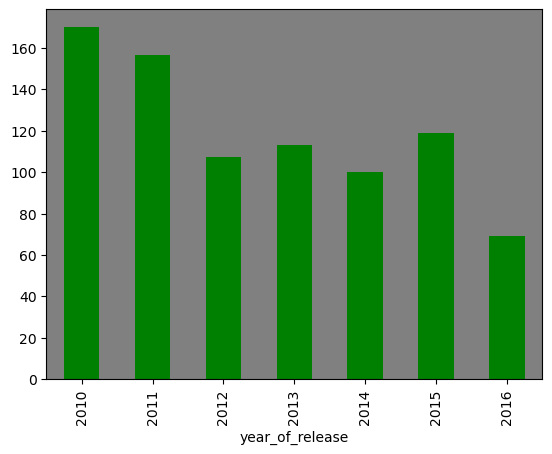

In [56]:
df10 = data_one.sort_values(by='my_sum', ascending=False)
df10 = df10.drop(columns = list(range(1980, 2010)))
df10  = df10.iloc[:, :-1]

ax1 = plt.axes()
ax1.set_facecolor("grey")

df10.max().plot.bar(color = 'green');

Общее количество продаж, как можно видеть, понижалось с каждым годом. Такая зависимость может коррелироваться например с тем, что в последние годы для игр стали активнее использовать ПК.

Можно ли сделать на основании полученных данных вывод о том, что игровая индустрия затухла к 2017 году?



Нет, потому что для более корректной оценки нам стоит посмотреть на другой показатель: отношение количество продаж к количеству лет, прошедших с момента её выпуска. В рассмотрение возьмём период с 2012 по 2016 год, так как для нас весомее будет именно самые последние актуальные данные по продажам.

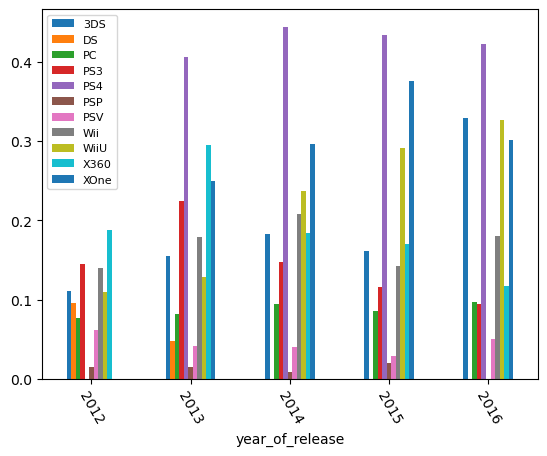

In [57]:
data_dif = data.assign(difference = (data['global_sales'] / (2017- data['year_of_release'])))
y_mask = (data_dif['year_of_release'] >= 2012) & (data_dif['year_of_release'] <= 2016)
data_dif = data_dif.loc[y_mask]

df = data_dif.pivot_table(
    values = 'difference',
    columns = 'year_of_release',
    index = 'platform',
    aggfunc = 'mean'
    ).T
df.plot.bar()
plt.xticks(rotation=-60)
plt.legend(prop={'size': 8});

 - Во-первых, хорошо видно платформы игры которых действительно продаются регулярно и очень успешно: PS4, Xone
 - Во-вторых, можно заметить платформы которые с каждым годом продаются всё лучше и лучше: WiiU
 - В-третьих, можно заметить платформы которые явно не являются перспективными для вложений: PSP, PS3

Рассмотрим влияние оценок пользователей и экспертов на общее число продаж.
Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

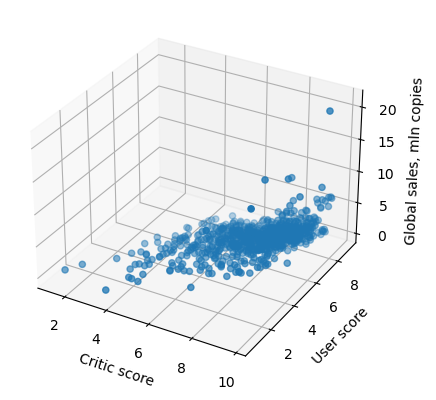

In [58]:
new.drop(new.tail(1).index, inplace=True)
maxi_ind = new.idxmax()
plat_max = maxi_ind.idxmax()

p_mask = (data['platform'] == plat_max) & (data['critic_count'] != 0) & (data['user_score'] != 0)
my_date = data.loc[p_mask]
my_date['critic_score'] = my_date['critic_score'].div(10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = my_date['critic_score']
y = my_date['user_score']
z = my_date['global_sales']

ax.scatter(x, y, z)

ax.set_xlabel("Critic score")
ax.set_ylabel("User score")
ax.set_zlabel("Global sales, mln copies");

Можем заметить следующую зависимость между оценками и количеством продаж:
- Пользователи заметно чаще оценивают продукты на максимальный балл, чем критики, что в целом довольно логично
- Можно заметить что игры выделяются высоким уровнем продаж в случае высоких оценок
- Игры имеющие средние рейтинги имеют примерно одинаковое кол-во продаж


Хочется также посмотреть, на какие оценки стоит обращать внимание - какие из них больше всего соотносятся с продажами

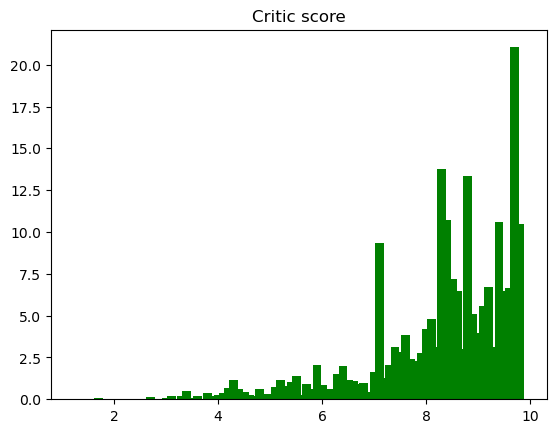

In [59]:
plt.bar(my_date['critic_score'], my_date['global_sales'], width = 0.17, color = 'green')
plt.title('Critic score');

In [60]:
data['global_sales'].corr(data['critic_score'])

0.1486080939383856

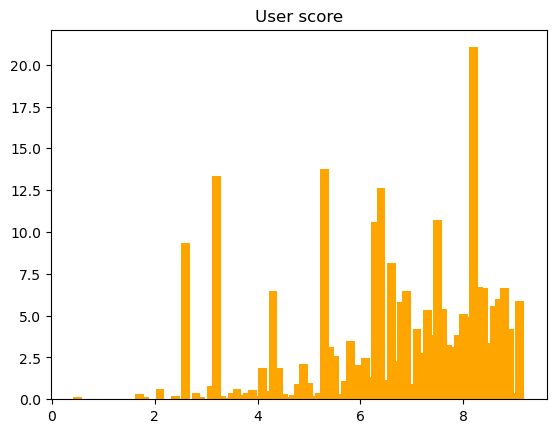

In [61]:
plt.bar(my_date['user_score'], my_date['global_sales'], width = 0.17, color = 'orange')
plt.title('User score');

In [62]:
data['global_sales'].corr(data['user_score'])

0.13608122383360347

Данные графики отражают отдельные зависимости количества продаж от оценки критиков в первом случае, от оценки пользователей во втором.
Рассчитанные значения корреляции соответствующих оценок с продажами на стороне критиков, т.е. доверять их оценкам в расчёте на хорошую продаваемость - рациональнее.

#### Сделаем выводы по каждой диаграмме в отдельности:
- Если рассматривать первую диаграмму, то можно заметить, что в общая тенденция отношения продаж к оценке соблюдается, т.е. чем выше оценка экспертов тем выше количество проданных экземпляров.
  - Однако, стоит также заметить, что есть и некоторые примеры, когда при средней оценке игры могли продаваться сильно лучше схожего по оценке продукта. Наверное, такое может произойти из-за того, что эксперт оценивает игры более шаблонно, чем пользователи, и как следствие не всегда понимают чем может завлечь тот или иной продукт.
- Если рассматривать вторую диаграмму, то здесь зависимость уже не прослеживается так явно. Конечно, чем выше рейтинг, тем, в среднем, игра будет лучше продаваться. Однако, по сравнению с первой ситуацией, гораздо больше случаев когда и игры с довольно низкими оценками попадают в топы продаж.
  - Почему же такое возможно? Предположительно, такое может быть когда игра является довольно сильно прорекламированной. Большое кол-во пользователей покупают эту игру, но их ожидания по поводу сюжета или каких-то механик не оправдываются, из-за чего, на своебразном "контрасте" люди и выставляют низкий балл.
- Стоит также заметить и одну очень популярную игру - которая имеет высокие баллы как у пользователей так и у критиков
- Также стоит заметить некоторые столбцы которые сильно выделяются на фоне остальных. Как видно, в большинстве они соответствуют и высоким оценкам, что довольно логично и говорит о возможно более востребованном жанре или более успешной рекламной компаниии

Далее рассмотрим распределение продаж для различных жанров игр:

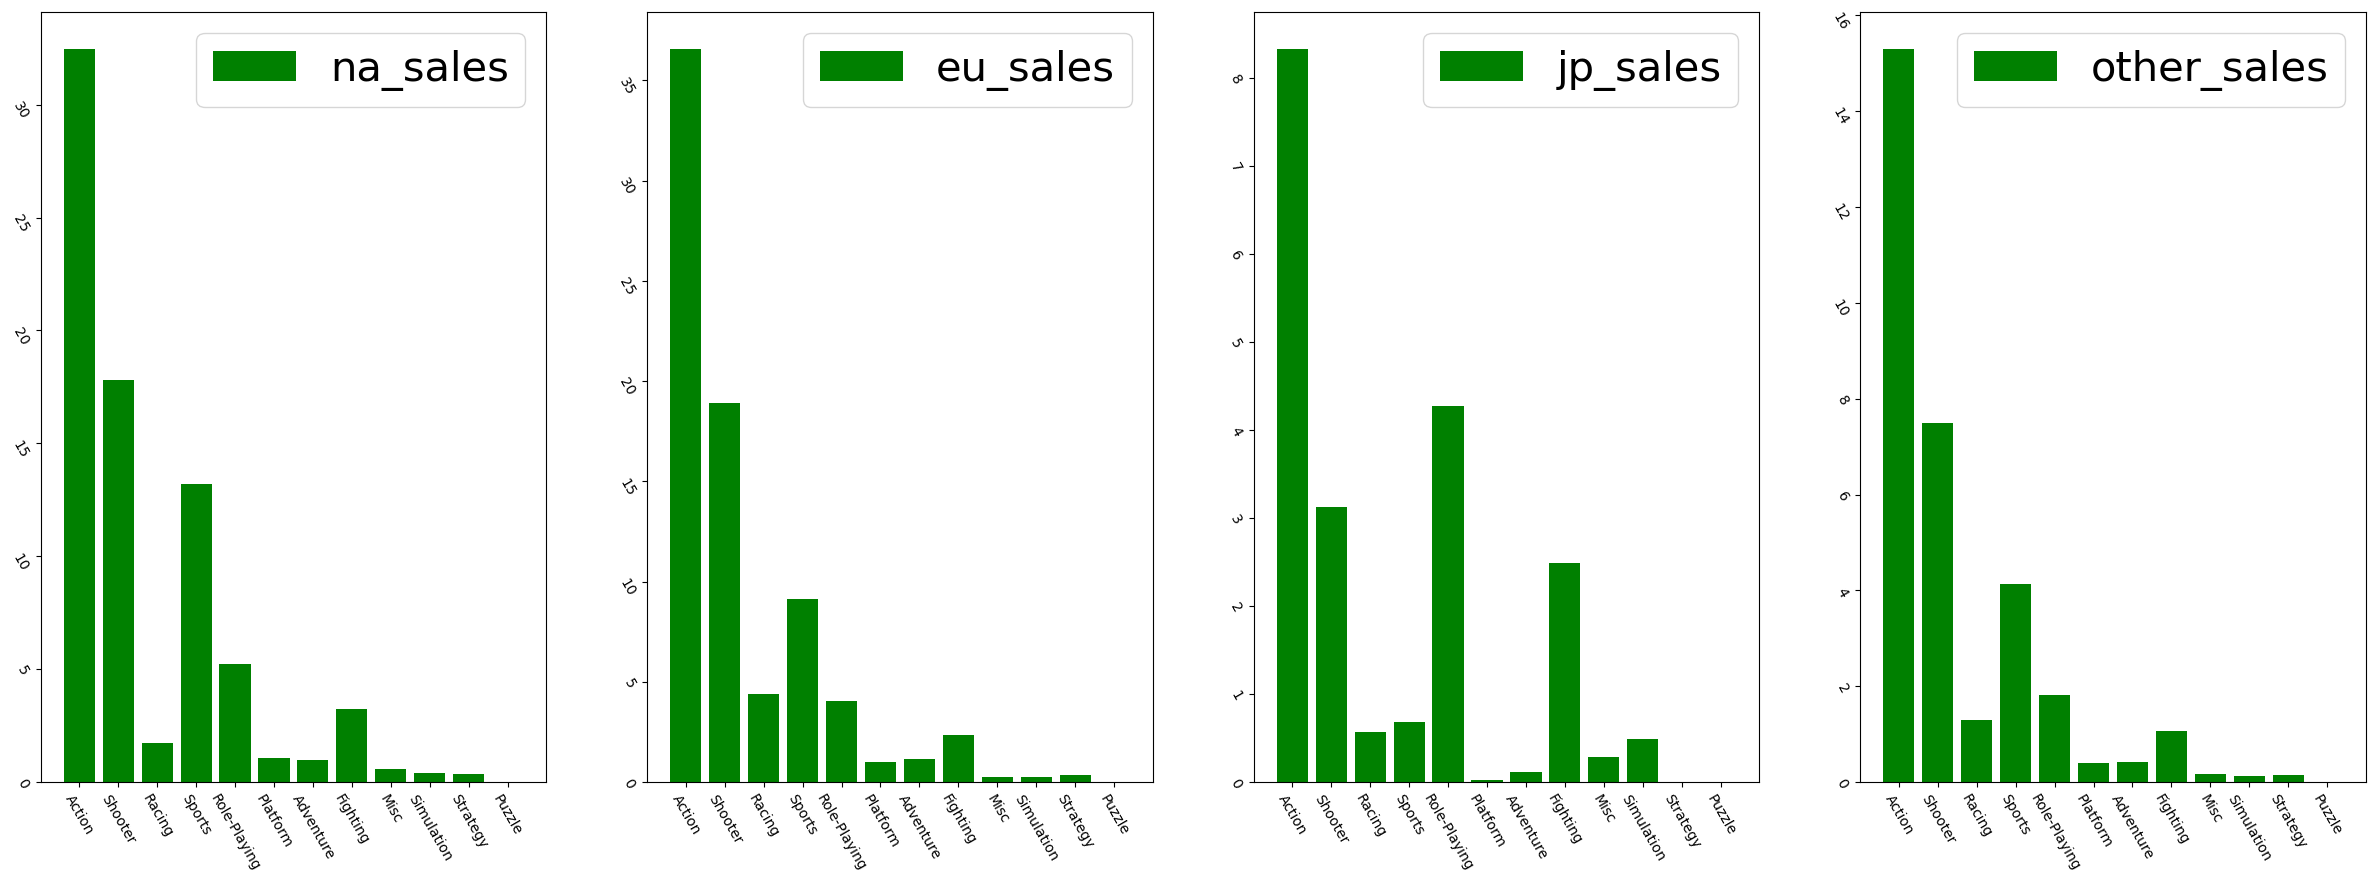

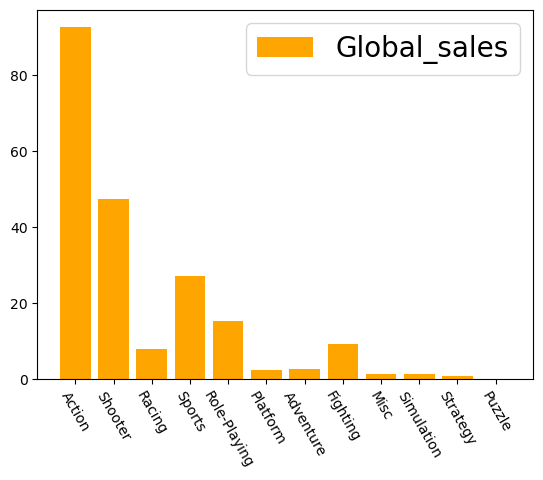

In [63]:
shoot_mask = (my_date['genre'] == 'Shooter')
shoot_date = my_date.loc[shoot_mask]

free_mass = []

arr = len(my_date['genre'].unique())
arr_name = my_date['genre'].unique()

for _ in range(len(my_date.axes[1])):
    if (my_date.columns[_].find('sales') != -1) and (my_date.columns[_] != 'global_sales'):
        free_mass.append(my_date.columns[_])
        
fig1, axx = plt.subplots(nrows=1, ncols=len(free_mass), figsize=(30, 10))

for i in range(len(free_mass)):

    curr_mass = np.zeros(arr)

    for j in range(arr):
        curr = (my_date['genre'] == arr_name[j]) & (my_date['year_of_release'] >= 2012)
        curr_my_date = my_date.loc[curr]
        curr_mass[j] = curr_my_date[free_mass[i]].sum(axis=0)

    axx[i].bar(arr_name, curr_mass, color='green', label=free_mass[i])
    axx[i].tick_params(labelrotation=-60)


for s in axx.flatten():
    s.legend(prop={'size': 30})

for k in range(arr):
    curr = (my_date['genre'] == arr_name[k]) & (my_date['year_of_release'] >= 2012)
    curr_my_date = my_date.loc[curr]
    curr_mass[k] = curr_my_date['global_sales'].sum(axis=0)

figg = plt.figure()
plt.bar(arr_name, curr_mass, label='Global_sales', color='orange')
plt.legend(prop={'size': 20})
plt.xticks(rotation=-60);

Для начала проанализируем картину по регионам. В данном случае выделяется 4 региона (данный результат был получен из того предположения, что все колонки с названиями регионов имеют одинаковое шаблонное название "название_региона"_sales).
- В Северной Америке можно заметить следующее:
  - Игры категории Action, Shooter и Sports являются самыми популярными
  - Игры категории Simulation, Strategy и Puzzle являются самыми непопулярными
- В Европе:
  - Игры категории Action, Shooter и Sports являются самыми популярными
  - Игры категории Simulation, Strategy и Puzzle являются самыми непопулярными
- В Японии:
  - Игры категории Action, Shooter и Role-Playing являются самыми популярными
  - Игры категории Platform, Strategy и Puzzle являются самыми непопулярными
- В остальных регионах:
  - Игры категории Action, Shooter и Sports являются самыми популярными
  - Игры категории Simulation, Strategy и Puzzle являются самыми непопулярными

Теперь проанализируем данные полученные для общих продаж по всем регионам:
  - Игры категории Action, Shooter и Sports являются самыми популярными
  - Игры категории Simulation, Strategy и Puzzle являются самыми непопулярными

## Составим портрет пользователя каждого из наших 4 регионов

### Найдём топ 5 самых популярных платформ


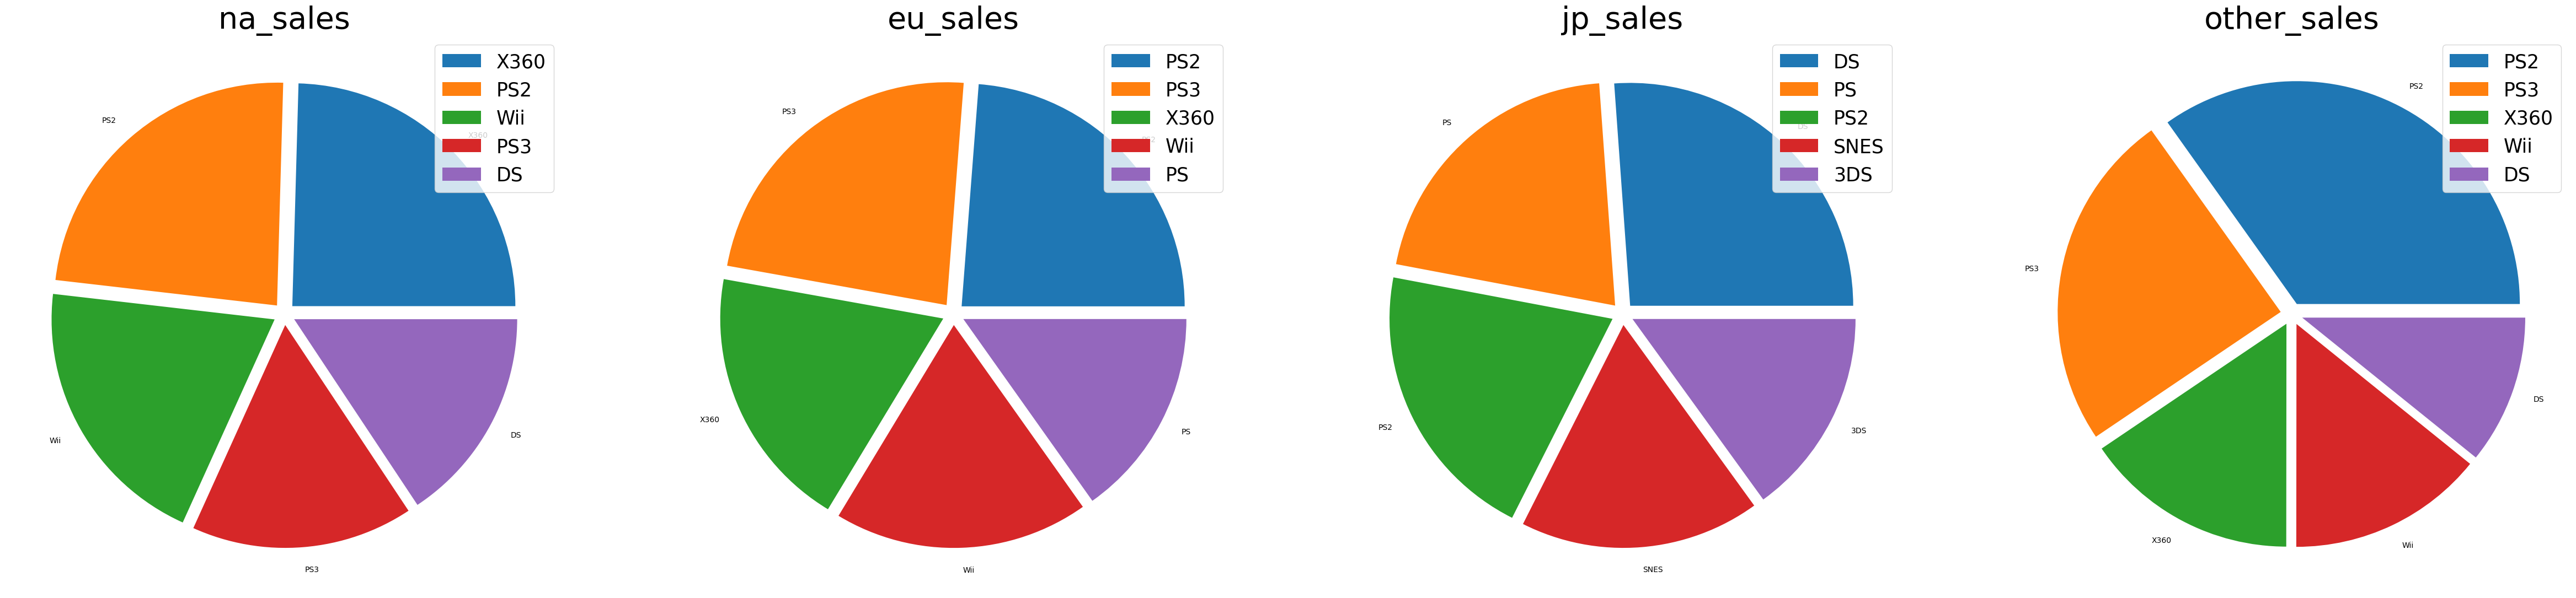

In [64]:
fig_2, aix = plt.subplots(nrows=1, ncols=4, figsize=(60, 20))

i, j = 0, 0
for _ in range(len(free_mass)):
    local_data = data.pivot_table(
            values=free_mass[_],
            columns='year_of_release',
            index='platform',
            aggfunc='sum'
        )
    local_data['my_sum'] = local_data.sum(axis=1)
    explode = (0.05, 0.05, 0.05, 0.05, 0.05)
    local_suc = local_data.sort_values(by='my_sum', ascending=False).head(5)
    aix[_].pie(local_suc['my_sum'].tolist(), labels=local_suc.index.tolist(), explode = explode)
    aix[_].set_title(free_mass[_], size=40)
    aix[_].legend(prop={'size': 25 });

Полученные данные интерпретируем так:
- Для Северной Америки:
  - Платформы PS2, X360, Wii - более популярные
  - Платформы PS3, DS - менее популярные
- Для Европы:
  - Платформы PS2, X360, Wii, PS3 - более популярные
  - Платформа PS - менее популярная
- Для Японии:
  - Платформы PS2, PS, DS,  - более популярные
  - Платформы 3DS, SNES - менее популярные
- Для остальных регионах:
  - Платформы PS2, PS3 - более популярные
  - Платформы X360, Wii, DS - менее популярные

Посмотрим на влияние рейтинга ESBR на продажи в отдельном регионе.
Приложу для пояснения толкование буквенных обозначений для этой организации:
- «EC» («Early childhood»)
- «E» («Everyone»)
- «E10+» («Everyone 10 and older»)
- «T» («Teen»)
- «M» («Mature») 
- «AO» («Adults Only 18+») 
- «NR» («Not Rated»)
- «RP 17+» («Rating Pending»)
- «Kids to Adults»

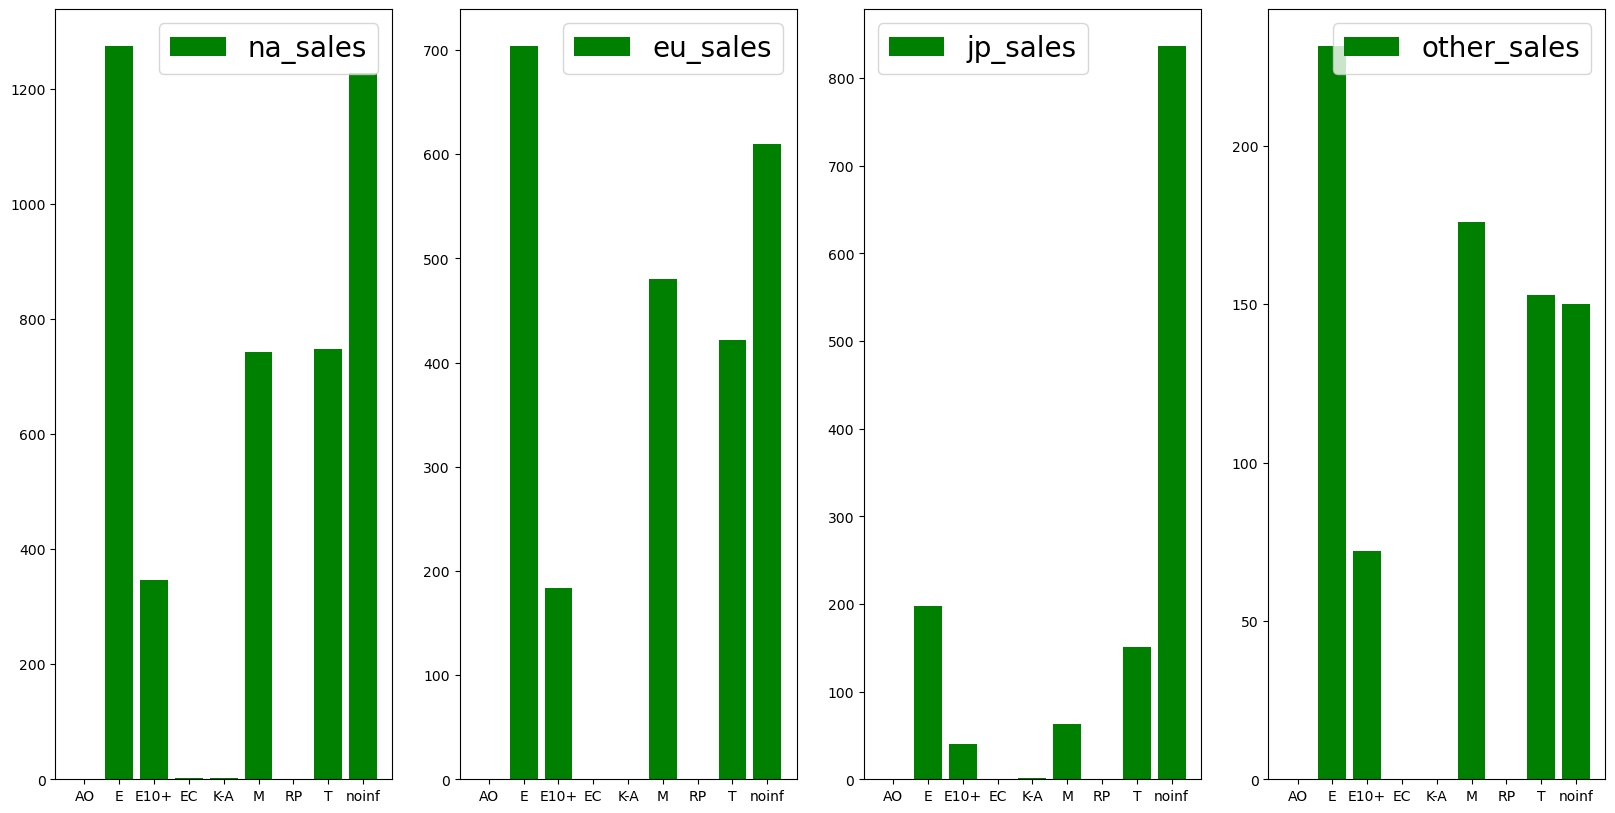

In [65]:
data['rating'] = data['rating'].replace(0, 'NR')

fig2, axe = plt.subplots(nrows=1, ncols=len(free_mass), figsize=(20, 10))

for sale in free_mass:
    date_for_me = data.pivot_table(
        values=sale,
        index='rating',
        aggfunc = 'sum'
    )
    bar_list = date_for_me[sale].tolist()
    index_list = date_for_me.index.tolist()
    axe[free_mass.index(sale)].bar(index_list, bar_list, label = sale, color = 'green')

for s in axe.flatten():
    s.legend(prop={'size': 20})


### Итог

Можно увидеть, что в регионах наблюдается следующая тенденция:
- В Северной Америке:
 - Самые продаваемые игры имеют оценку Everyone и NR 
   - Неоценённые игровые продукты также имеют высокий спрос, что понятно, так как, даже в случае малого их количества, в них смешиваются игры всех жанров
 - Самые непопулярные игры имеют оценки: AO, EC, K.-A., RP
- В Европе:
  - Самые продаваемые игры имеют оценку Everyone и NR
  - Самые непопулярные игры имеют оценки: AO, EC, K.-A., RP
- В Европе:
 - Самые продаваемые игры имеют оценку Everyone и NR
 - Самые непопулярные игры имеют оценки: AO, EC, K.-A., RP
- В Европе:
 - Самые продаваемые игры имеют оценку Everyone, NR, M
 - Самые непопулярные игры имеют оценки: AO, EC, K.-A., RP
  

### Проверим 2 гипотезы:

##### Сформулируем нулевую и альтернативную гипотезу для первой ситуации:
 - Нулевая гипотеза:
   - Средние пользовательские рейтинги платформ Х360 И РС одинаковые
 - Альтернативная гипотеза:
   - Средние пользовательские рейтинги платформ Х360 и РС различные

In [66]:
PC_mask = (data['platform'] == 'PC') & (data['user_score'] != 0)
Xbox_mask = (data['platform'] == 'X360') & (data['user_score'] != 0)

PC_date = data.loc[PC_mask]
Xbox_date = data.loc[Xbox_mask]

pc_score = PC_date['user_score']
xbox_score = Xbox_date['user_score']

ttest_ind(pc_score, xbox_score)

Ttest_indResult(statistic=5.31776579983428, pvalue=1.1898768801646006e-07)

Получили pvalue < 0.05, что означает, что нулевая гипотеза неверна и средние рейтинги платформ различны

##### Сформулируем нулевую и альтернативную гипотезу для второй ситуации:
 - Нулевая гипотеза:
   - Средние пользовательские рейтинги платформ Action и Sports одинаковые
 - Альтернативная гипотеза:
   - Средние пользовательские рейтинги платформ Action и Sports различные

In [67]:
Act_mask = (data['genre'] == 'Action') & (data['user_score'] != 0)
Sport_mask = (data['genre'] == 'Sports') & (data['user_score'] != 0)

Act_date = data.loc[Act_mask]
Sport_date = data.loc[Sport_mask]

act_user_av = Act_date['user_score']
sport_user_av = Sport_date['user_score']

ttest_ind(sport_user_av, act_user_av)

Ttest_indResult(statistic=-1.8472797735322193, pvalue=0.06480928064420527)

Получили pvalue > 0.05, что означает, что нулевая гипотеза верна и средние рейтинги платформ одинаковы

### Итог
По порядку:

 - Начнём с того, что на основании наших данных: 
  - Диаграммы для продаж каждой из платформ 
    - **Игровая индустрия развивается с каждым годом и продажи с игр становятся всё больше и больше**.

 - Определили также и компании, в которые мы хотели бы вкладываться: 

 - Провели сравнение для таких величин как: 
   - Отношение количества продаж в единицу времени (млн шт/ год)
   - Построили персональный портрет пользователя каждого региона как для платформ, так и для жанров:

    - Исходя из полученных результатов такими компаниями оказались: **PS4** и **Xone** как компании с уже стабильными продажами и компания **Wiiu** как компания, потенциальный рост продаж которой очень обнадёживает и выглядит привлекательным для инвестиций.

 - Были исследованы корреляции между оценками игры и оценками критиков с количеством общих продаж:
  - Построена трёхмерная диаграмма рассеяния для оценок обоих сторон и общих продаж
  - Численно рассчитана корреляция оценка / продажи.
    - Полученный результат получился таким, каким и предполагалось: **оценки критиков лучше соотносятся с количеством проданных экземпляров**
 - Определили жанры, который также кажутся нам самыми привлекательными для аудитории.
  - Построили диграммы для продаж каждого региона
  - Построили диаграммы для суммарных продаж по миру
    - Лучшие результаты показали такие жанры: **Action**, **Sports**, **Shooter**